In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup


In [2]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

In [8]:
# install this specific version
#! pip install albumentations==0.5.2

### Pre Processing

##### Visualization

In [4]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

##### Albumenations

In [5]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

In [6]:
# transforming the dataset with albumenations
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

In [9]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

/home/alex/.local/lib/python3.8/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


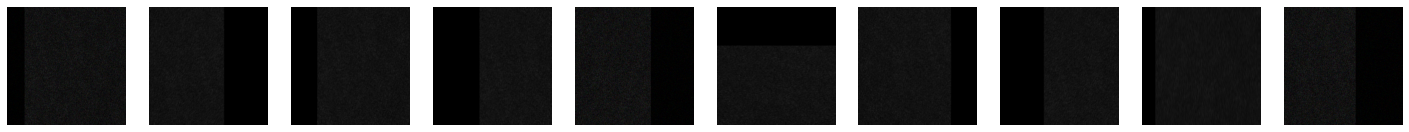

In [10]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')


In [12]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

In [11]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

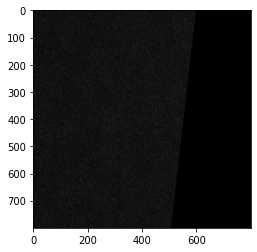

In [13]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)